## ANALYSIS

In [177]:
# RESULT_JSON = "/Users/law/repos/viper/results/all_ops/all_ops_2020-06-10-18-53.json"
# RESULT_JSON = "/Users/law/repos/viper/results/all_ops/all_ops_2020-06-15-12-10.json"
RESULT_JSON = "/Users/law/repos/viper/results/all_ops/all_ops_2020-06-15-12-13.json"

In [178]:
import json

results_raw = json.loads(open(RESULT_JSON).read())
# assert results_raw["context"]["library_build_type"] != "debug"
BENCHMARKS =  results_raw["benchmarks"]
# print(BENCHMARKS)

In [179]:
from collections import defaultdict
runs = defaultdict(list)

ROCKS_DISK = ('DiskRocksDb', "RocksDB-SSD")
ROCKS_NVM = ('PmemRocksDb', "RocksDB-NVM")
PMEMKV = ('PmemKV', "PmemKV")
VIPER = ('Viper', 'Viper')
DRAM_MAP = ('DramMap', 'TBB Map')
FASTER = ('Faster', "FASTER")

ALL_FIXTURES = [VIPER, PMEMKV, DRAM_MAP, ]#ROCKS_DISK, ROCKS_NVM,]
ALL_BM_TYPES = ['insert', 'get', 'update', 'delete']

def get_bm_type(bm_type_str):
    for t in ALL_BM_TYPES:
        if t in bm_type_str:
            return t
    raise RuntimeError(f"Unknown bm_type: {bm_type_str}")

for bm in BENCHMARKS:
    found = False
    for (fixture, _) in ALL_FIXTURES:
        bm_type = get_bm_type(bm['name'])
        if fixture in bm['name']:
            runs[(fixture, bm_type)].append(bm)
            found = True
            break
    if not found: raise RuntimeError(f"Unknown fixture {bm['name']}")

for fixture, _ in ALL_FIXTURES:
    for bm_type in ALL_BM_TYPES:
        runs[(fixture, bm_type)].sort(key=lambda x: x['threads'])

pprint.pprint(runs)

defaultdict(<class 'list'>,
            {('DramMap', 'delete'): [{'cpu_time': 10601.033999999565,
                                      'found': 50000.0,
                                      'items_per_second': 4705715.531116435,
                                      'iterations': 1,
                                      'name': 'DramMapFixture/delete/100000/50000/iterations:1/repeats:1/real_time/threads:1',
                                      'real_time': 10625.589173287153,
                                      'repetition_index': 0,
                                      'repetitions': 1,
                                      'run_name': 'DramMapFixture/delete/100000/50000/iterations:1/repeats:1/real_time/threads:1',
                                      'run_type': 'iteration',
                                      'threads': 1,
                                      'time_unit': 'us'},
                                     {'cpu_time': 6723.315999999706,
                          

                                     'repetitions': 1,
                                     'run_name': 'PmemKVFixture/insert/100000/100000/iterations:1/repeats:1/real_time/threads:24',
                                     'run_type': 'iteration',
                                     'threads': 24,
                                     'time_unit': 'us'},
                                    {'cpu_time': 128345.05562499998,
                                     'items_per_second': 772106.2547444591,
                                     'iterations': 32,
                                     'name': 'PmemKVFixture/insert/100000/100000/iterations:1/repeats:1/real_time/threads:32',
                                     'real_time': 4048.665557093045,
                                     'repetition_index': 0,
                                     'repetitions': 1,
                                     'run_name': 'PmemKVFixture/insert/100000/100000/iterations:1/repeats:1/real_time/threads:32',
 

                                    'threads': 32,
                                    'time_unit': 'us'},
                                   {'cpu_time': 7082.02013888889,
                                    'items_per_second': 14085765.844582401,
                                    'iterations': 36,
                                    'name': 'ViperFixture/insert/100000/100000/iterations:1/repeats:1/real_time/threads:36',
                                    'real_time': 197.22037343595775,
                                    'repetition_index': 0,
                                    'repetitions': 1,
                                    'run_name': 'ViperFixture/insert/100000/100000/iterations:1/repeats:1/real_time/threads:36',
                                    'run_type': 'iteration',
                                    'threads': 36,
                                    'time_unit': 'us'}],
             ('Viper', 'update'): [{'cpu_time': 213435.3029999998,
                         

## PLOTS

In [180]:
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
rcParams.update(json.loads(open("matplot_conf.json").read()))

import pprint
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

MILLION = 1_000_000

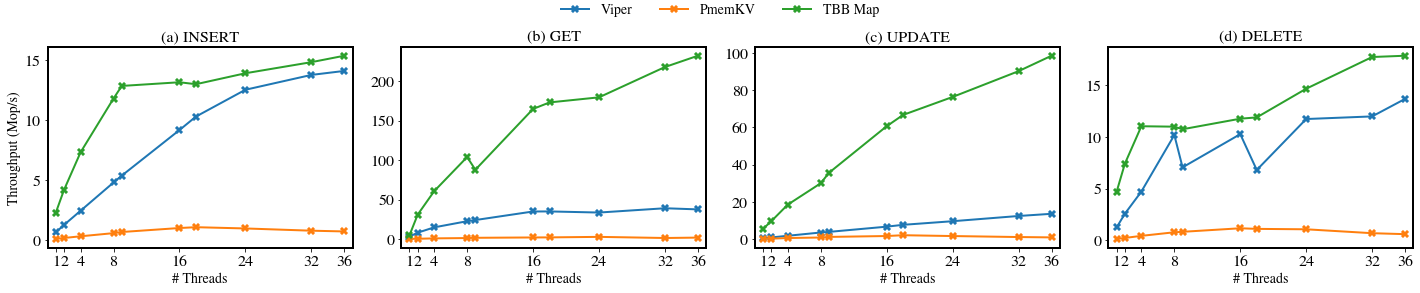

In [181]:
fig, (insert_ax, get_ax, update_ax, delete_ax) = plt.subplots(1, 4, figsize=(20, 4))

def get_bm_ax(bm_type):
    if bm_type == 'insert': return insert_ax
    if bm_type == 'get': return get_ax
    if bm_type == 'update': return update_ax
    if bm_type == 'delete': return delete_ax
    raise RuntimeError(f"Unknown bm_type {bm_type}")

num_threads = sorted({run['threads'] for run in list(runs.values())[0]})

for bm_type, letter in zip(ALL_BM_TYPES, ['a', 'b', 'c', 'd']):
    ax = get_bm_ax(bm_type)
    ax.set_xlabel("# Threads")
    ax.set_title(f"({letter}) {bm_type.upper()}")
    for (fixture, _) in ALL_FIXTURES:
        r = [run['items_per_second'] / MILLION for run in runs[(fixture, bm_type)]]
        ax.plot(num_threads, r, marker='X', ms=8, markeredgewidth=0.1, lw=2)
    x_ticks = np.append(ax.get_xticks(), 36)
    ax.set_xticks([1, 2, 4, 8, 16, 24, 32, 36])
    ax.set_xlim(0, 37)

# ax.plot(num_threads, rocks_disk_runs, label="DIMM", ls='-', color='grey')
# ax.plot(num_threads, rocks_nvm_runs, label="Block", ls='--', color='#BA2121')

insert_ax.set_ylabel("Throughput (Mop/s)")
# fig.legend(frameon=True, loc="upper center", borderaxespad=0.1,) #, bbox_to_anchor=(0.55, 0.54))
fig.legend(loc='upper center', labels=[f[1] for f in ALL_FIXTURES], bbox_to_anchor=(0.5, 1.05), ncol=6, frameon=False)

# ax.grid(axis='y', which='major')
# fig.savefig('charts/all_ops.pdf', bbox_inches='tight')